## **Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?** ##

In [4]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import os


## Cleaning DataFrame ##

In [6]:
pd.options.mode.copy_on_write = True
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
States_df = pd.read_csv('../data/States_df.csv')

In [8]:
States_df['Party'] = States_df['FirstLastP'].str.split(' ').str[-1].str.strip('()')

In [9]:
States_df = (
    States_df
    .rename(columns={'Incumbent':'x', 'Rcpts': 'Raised', 'Result': 'Outcome', 'CRPICO': 'Incumbent'})
)

In [10]:
data = States_df[['FirstLastP', 'State', 'District', 'Raised', 'Spent', 'Outcome', 'Party', 'Incumbent']]

In [11]:
data['Outcome'] = data['Outcome'].replace(' ', 'L')

In [12]:
data['Winner'] = (data['Outcome'] == 'W') | (data['Outcome'] == 'w')

In [13]:
data['Winner'] = data['Winner'].astype(int)

In [14]:
data['Difference'] = data['Raised'] - data['Spent']

In [15]:
df = data[['State', 'District', 'FirstLastP', 'Party', 'Raised', 'Spent', 'Difference', 'Outcome', 'Winner', 'Incumbent']]

In [16]:
df = df[df['Difference'] != 0.00]

## Descriptive Statistics ##

In [18]:
#df.to_csv('../data/States_clean_df.csv', index=False)

In [19]:
incumb_df = df.groupby(['State', 'Incumbent', 'Party', 'Winner']).agg({'Raised':'mean', 'Spent':'mean', 'Difference':'mean'}).reset_index()

In [20]:
#incumb_df.to_csv('../data/incumb_df.csv', index=False)

In [345]:
R_df_filter = incumb_df[incumb_df['Party'].isin(['R'])]

In [343]:
D_df_filter = incumb_df[incumb_df['Party'].isin(['D'])]

In [347]:
D_df_filter

,State,Incumbent,Party,Winner,Raised,Spent,Difference
0,Alabama,C,D,0,50273.20,40971.09,9302.11
1,Alabama,I,D,1,2168165.01,1495957.14,672207.87
3,Alabama,O,D,0,68072.32,67480.65,591.66
7,Arizona,C,D,0,1773053.82,1750995.91,22057.91
10,Arizona,I,D,1,1977629.63,1603944.16,373685.47
...,...,...,...,...,...,...,...
254,West Virginia,C,D,0,90123.04,90324.82,-201.78
256,Wisconsin,C,D,0,625729.03,601206.10,24522.92
258,Wisconsin,I,D,1,1821279.60,2205589.69,-384310.09
260,Wisconsin,O,D,0,370392.34,371799.41,-1407.07


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


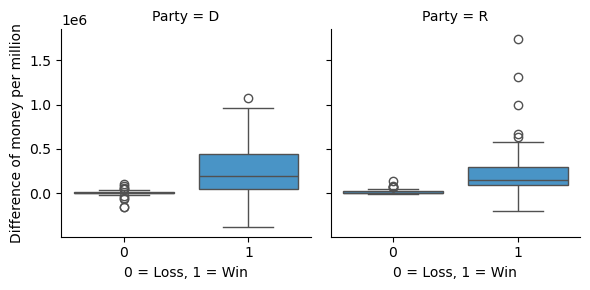

In [142]:
g = sns.FacetGrid(incumb_df_filter, col='Party')
g.map(sns.boxplot, 'Winner', 'Difference')
g.set_axis_labels("0 = Loss, 1 = Win", "Difference of money per million")
plt.show()
g.savefig('../images/diff_facet.png', dpi=150)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


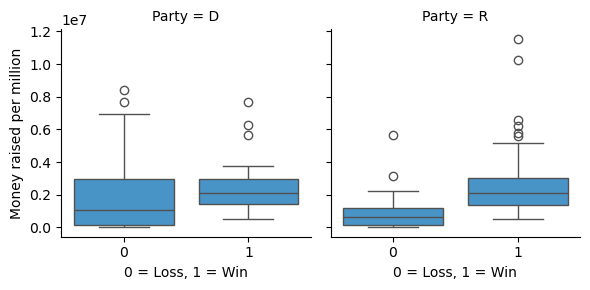

In [411]:
gg = sns.FacetGrid(incumb_df_filter, col='Party')
gg.map(sns.boxplot, 'Winner', 'Raised')
gg.set_axis_labels("0 = Loss, 1 = Win", "Money raised per million")
plt.show()

In [413]:
gg.savefig('../images/raised_facet.png', dpi=150)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


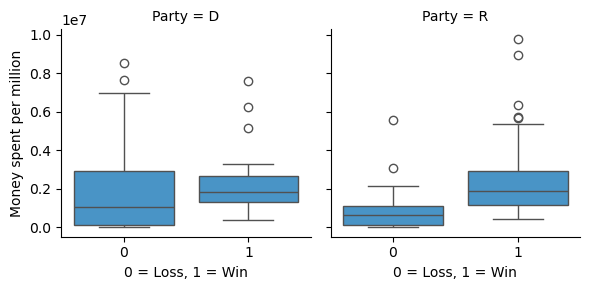

In [415]:
ggg = sns.FacetGrid(incumb_df_filter, col='Party')
ggg.map(sns.boxplot, 'Winner', 'Spent')
ggg.set_axis_labels("0 = Loss, 1 = Win", "Money spent per million")
plt.show()

In [417]:
ggg.savefig('../images/spent_facet.png', dpi=150)

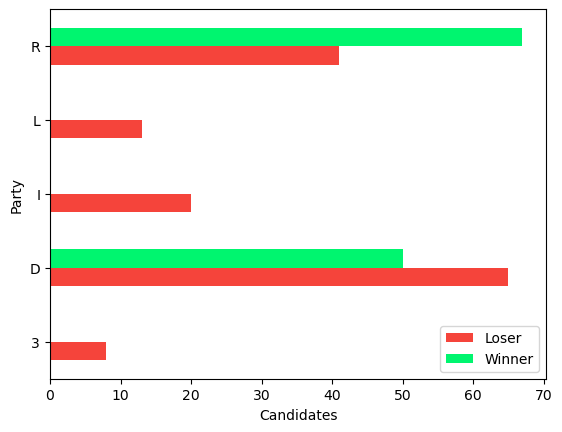

In [431]:
color = (['#F5443B', '#00F56F'])

pd.crosstab(
    incumb_df['Party'],
    incumb_df['Winner']
).plot(kind="barh", color=color, xlabel='Candidates')
plt.legend(['Loser', 'Winner'])
#plt.savefig('../images/party_wins.png', dpi=150);

In [331]:
df_logreg = smf.logit("Winner ~ Spent", data = incumb_df).fit()

Optimization terminated successfully.
         Current function value: 0.638032
         Iterations 5


In [333]:
df_logreg.params

Intercept   -0.85
Spent        0.00
dtype: float64

In [349]:
df_lin = smf.ols("Spent ~ Raised", data=incumb_df).fit()

In [357]:
D_df_lin = smf.ols("Spent ~ Raised", data=D_df_filter).fit()

In [359]:
R_df_lin = smf.ols("Spent ~ Raised", data=R_df_filter).fit()

In [361]:
D_df_lin.params

Intercept   -79734.84
Raised           0.98
dtype: float64

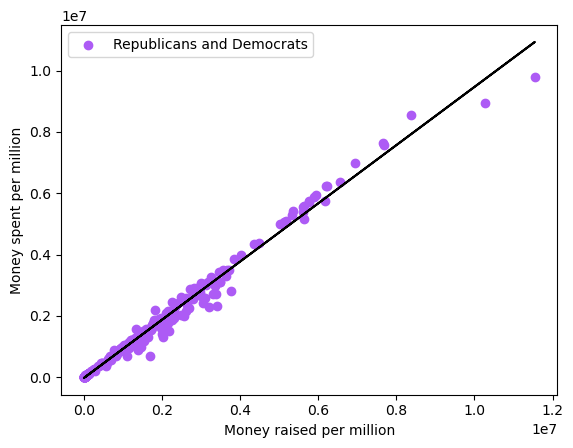

In [434]:
plt.scatter(data=incumb_df, x='Raised', y='Spent', color='#AD5BF5')
plt.plot(incumb_df['Raised'], df_lin.fittedvalues, color='black')
plt.xlabel('Money raised per million')
plt.ylabel('Money spent per million')
plt.legend(['Republicans and Democrats'])
#plt.savefig('../images/repub_demo_spent_raised.png', dpi=150);
plt.show()

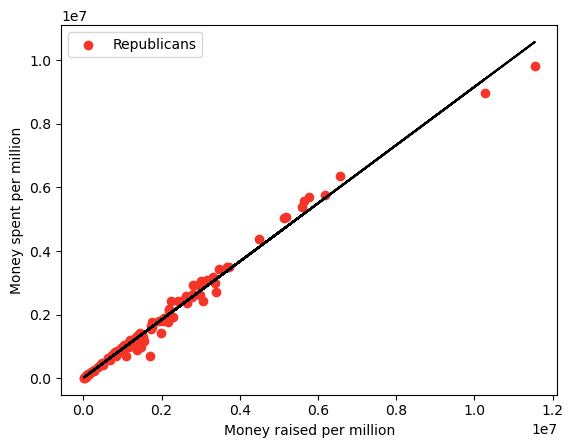

In [436]:
plt.scatter(data=R_df_filter, x='Raised', y='Spent', color='#F43528')
plt.plot(R_df_filter['Raised'], R_df_lin.fittedvalues, color='black')
plt.xlabel('Money raised per million')
plt.ylabel('Money spent per million')
plt.legend(['Republicans'])
#plt.savefig('../images/repub_spent_raised.png', dpi=150)
plt.show();

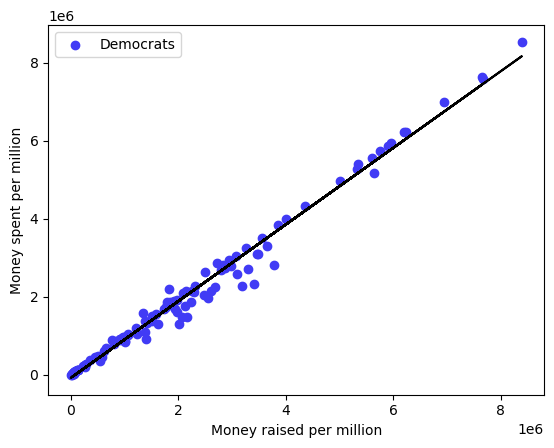

In [438]:
plt.scatter(data=D_df_filter, x='Raised', y='Spent', color='#413BF5')
plt.plot(D_df_filter['Raised'], D_df_lin.fittedvalues, color='black')
plt.xlabel('Money raised per million')
plt.ylabel('Money spent per million')
plt.legend(['Democrats'])
#plt.savefig('../images/demo_spent_raised.png', dpi=150)
plt.show();

In [407]:
for i, j in zip(df['FirstLastP'], df['Difference']):
    print(i, j)

Jerry Carl (R) 111972.59000000008
James Averhart (D) 1121.7099999999919
Barry Moore (R) -18560.95000000007
Phyllis Harvey-Hall (D) 61.609999999993306
Mike D Rogers (R) -25452.32999999984
Adia Winfrey (D) 9302.11
Robert B Aderholt (R) -68735.96999999997
Mo Brooks (R) 445319.6699999999
Gary Palmer (R) -1863.4199999999255
Terri Sewell (D) 672207.8699999999
Don Young (R) 132453.06999999983
Alyse Galvin (I) 90348.61000000034
Tom O'Halleran (D) 57215.26000000024
Tiffany Shedd (R) 59913.669999999925
Ann Kirkpatrick (D) 465096.76
Brandon Martin (R) -6246.519999999902
Raul M Grijalva (D) 188052.93000000005
Daniel Wood (R) -539.4100000000035
Paul Gosar (R) -107740.73999999999
Delina DiSanto (D) -2590.3099999999977
Andy Biggs (R) 365801.3500000001
Joan Greene (D) 146279.38
David Schweikert (R) 15349.660000000149
Hiral Tipirneni (D) -65629.0399999991
Tom Lewellen (I) 685.1599999999999
Ruben Gallego (D) 157793.18999999994
Josh Barnett (R) 10210.330000000002
Debbie Lesko (R) 617792.2599999999
Michae